In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

In [2]:
n_instance = 10
n_agents = 2
actions_space = np.arange(1.2, 2.0, 0.04)
n_actions = actions_space.size
state_ravel = (n_actions,)*n_agents

In [3]:
quality = np.ones(n_agents)*2
margin_cost = np.ones(n_agents)
horizon = 1/4
a0 = 0
def replay_classic_reward(action):
    # Compute profits for all agents
    price = actions_space[action]
    demand = np.exp((quality - price) / horizon)
    demand = demand / (np.sum(demand) + np.exp(a0 / horizon))
    reward = np.multiply(price - margin_cost, demand)
    return reward

In [4]:
R = np.zeros((n_actions, n_actions))
for agent0 in range(n_actions):
    for agent1 in range(n_actions):
        r = replay_classic_reward([agent0, agent1])
        R[agent0, agent1] = r[0]

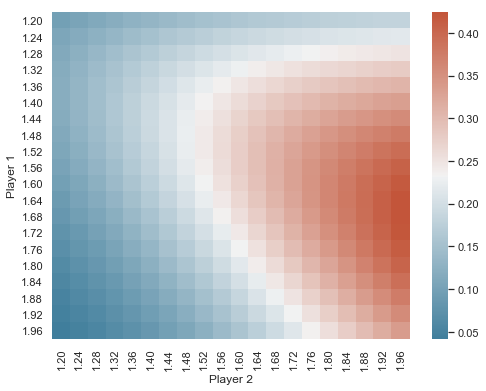

In [5]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
labels = ['{:,.2f}'.format(x) for x in actions_space]
ax = sns.heatmap(R, xticklabels=labels, yticklabels=labels,cmap=cmap) # cbar_kws={"label": "Reward"}
plt.xlabel('Player 2')
plt.ylabel('Player 1')
# cbar = ax.figure.colorbar(ax.collections[0])
# plt.savefig('reward.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()        

In [19]:
with open('AER_ratio.pickle', 'rb') as fp:
    AER_ratio = pickle.load(fp)

# with open('Ineq_ratio.pickle', 'rb') as fp:
#     Ineq_ratio = pickle.load(fp)

In [20]:
AER_ratio.diagonal().mean(), Ineq_ratio.diagonal().mean()

(0.6291938319752751, 0.8420008259126298)

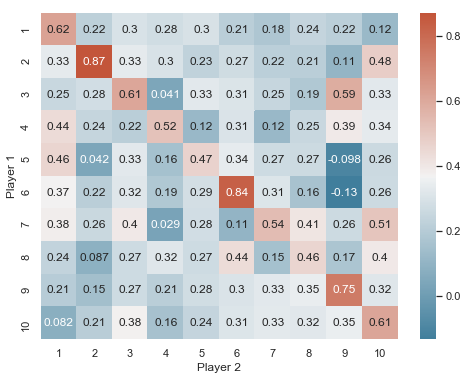

In [22]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
labels = np.arange(1, 11)
ax = sns.heatmap(AER_ratio, xticklabels=labels, yticklabels=labels, annot=True, cmap=cmap)
plt.xlabel('Player 2')
plt.ylabel('Player 1')
# cbar = ax.figure.colorbar(ax.collections[0])
# plt.savefig('ratio_aer.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [5]:
with open('aver05_Q.pickle', 'rb') as fp:
    aver_Q = pickle.load(fp)

# with open('aver05_end_price.pickle', 'rb') as fp:
#     aver_end_price = pickle.load(fp)

In [9]:
# with open('Q_hist_tol.pickle', 'rb') as fp:
#     tol_Q = pickle.load(fp)

# with open('end_price_tol.pickle', 'rb') as fp:
#     tol_price = pickle.load(fp)

In [4]:
with open('tol001_Q.pickle', 'rb') as fp:
    tol_Q = pickle.load(fp)

with open('tol001_end_price.pickle', 'rb') as fp:
    tol_price = pickle.load(fp)

In [5]:
# Tol Ratio matrix calculator
N = 200000
monopoly = replay_classic_reward([18, 18])[0]
nash = replay_classic_reward([7, 7])[0]

ss = np.random.SeedSequence(12345)
# Last a few rngs for sampling memories
child_seeds = ss.spawn(n_agents)
rng = [np.random.default_rng(s) for s in child_seeds]

tol_ratio = np.zeros((n_instance, n_instance))

for agent0 in range(n_instance):
    for agent1 in range(n_instance):
        sim_Q = np.zeros((n_agents, n_actions**n_agents, n_actions))
        sim_Q[0, :, :] = tol_Q[agent0][0, :, :]
        sim_Q[1, :, :] = tol_Q[agent1][1, :, :]
        init = np.zeros(n_agents, dtype=int)
        for i in range(n_agents):
            init[i] = rng[i].integers(0, n_actions, size=1)
        state = np.ravel_multi_index(init, state_ravel)
#         state = np.random.randint(0, n_actions**n_agents, size=1)
        action = np.zeros(n_agents, dtype=int)
        reward = np.zeros(n_agents)
        for k in range(N):
            # For each agent, select and perform an action
            for i in range(n_agents):
                action[i] = sim_Q[i, state].argmax()
            if k > N - 10000:
                reward += replay_classic_reward(action)
            # Move to the next state
            state = np.ravel_multi_index(action, state_ravel)
            avg = np.sum(reward)/10000/n_agents
            tol_ratio[agent0, agent1] = (avg - nash)/(monopoly - nash)
#         print('Instance', agent0, 'vs', agent1, avg, 'ratio', tol_ratio[agent0, agent1])

In [6]:
# Aver Ratio matrix calculator
N = 200000
monopoly = replay_classic_reward([18, 18])[0]
nash = replay_classic_reward([7, 7])[0]

ss = np.random.SeedSequence(12345)
# Last a few rngs for sampling memories
child_seeds = ss.spawn(n_agents)
rng = [np.random.default_rng(s) for s in child_seeds]

aver_ratio = np.zeros((n_instance, n_instance))

for agent0 in range(n_instance):
    for agent1 in range(n_instance):
        sim_Q = np.zeros((n_agents, n_actions**n_agents, n_actions))
        sim_Q[0, :, :] = aver_Q[agent0][0, :, :]
        sim_Q[1, :, :] = aver_Q[agent1][1, :, :]
        init = np.zeros(n_agents, dtype=int)
        for i in range(n_agents):
            init[i] = rng[i].integers(0, n_actions, size=1)
        state = np.ravel_multi_index(init, state_ravel)
#         state = np.random.randint(0, n_actions**n_agents, size=1)
        action = np.zeros(n_agents, dtype=int)
        reward = np.zeros(n_agents)
        for k in range(N):
            # For each agent, select and perform an action
            for i in range(n_agents):
                action[i] = sim_Q[i, state].argmax()
            if k > N - 10000:
                reward += replay_classic_reward(action)
            # Move to the next state
            state = np.ravel_multi_index(action, state_ravel)
            avg = np.sum(reward)/10000/n_agents
            aver_ratio[agent0, agent1] = (avg - nash)/(monopoly - nash)
#         print('Instance', agent0, 'vs', agent1, avg, 'ratio', aver_ratio[agent0, agent1])

In [8]:
1/1000/0.05

0.02

In [7]:
tol_ratio.diagonal()

array([0.80998181, 0.55398183, 0.58976734, 0.58103825, 0.51117902,
       0.44084734, 0.46418186, 0.66123124, 0.56844797, 0.41039129])

In [15]:
# LAM = -/MEM_SIZE/0.5 Simulated Ratio
aver = np.array([ 0.2859407 ,  0.12170294,  0.01820986, -0.30996826, -0.12809986,
                 -0.03161086, -0.13920194, -0.45591533, -0.11875279, -0.32310282])

# LAM = 1/MEM_SIZE/0.05 Simulated Ratio
tol = np.array([0.75023822, 0.93250101, 0.93591032, 0.41974075, 0.90971576,
                0.92656322, 0.73407456, 0.84459248, 0.98900363, 0.84945931])

# Indif (AER)
indif = np.array([0.62075367, 0.87099466, 0.61114998, 0.52129677, 0.46779278,
                  0.83529688, 0.53940583, 0.46263388, 0.74909819, 0.61351567])

df1 = pd.DataFrame({'Ratio':indif, 'Lambda':np.zeros(n_instance)})
df2 = pd.DataFrame({'Ratio':tol, 'Lambda':np.ones(n_instance)/1000/0.05})
df3 = pd.DataFrame({'Ratio':aver, 'Lambda': -np.ones(n_instance)/1000/0.5})
frames = [df1, df2, df3]
df = pd.concat(frames)

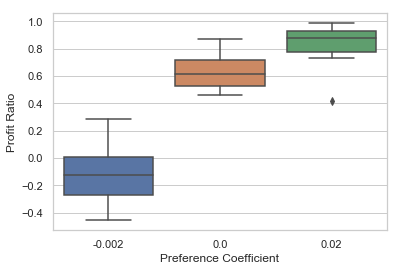

In [16]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Lambda", y="Ratio", data=df)
ax.set_xlabel("Preference Coefficient") # , fontsize=14)
ax.set_ylabel("Profit Ratio")
plt.savefig('tabular_box.eps', format='eps', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

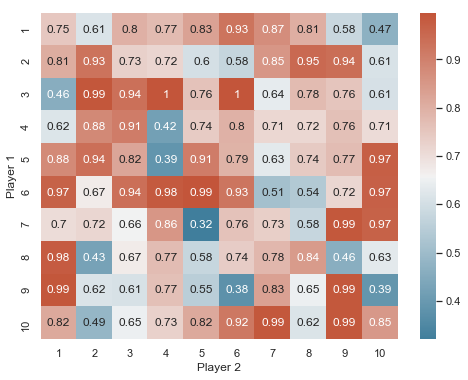

In [75]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
labels = np.arange(1, 11)
ax = sns.heatmap(tol_ratio, xticklabels=labels, yticklabels=labels, annot=True, cmap=cmap)
plt.xlabel('Player 2')
plt.ylabel('Player 1')
# cbar = ax.figure.colorbar(ax.collections[0])
plt.savefig('tol_ratio.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()